In [178]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [179]:
#Cleaning metadata
# In[147]:
metadata=pd.read_csv("movie_metadata_with_score_metacritic.csv", index_col="Unnamed: 0") #reading in metacritic dataset

In [180]:
metadata=metadata.loc[~metadata["metacritic_metascore"].isna()] #removing rows with no metacritic data


In [181]:
metadata=metadata.drop(["homepage","keywords","overview","status","tagline","imdb_metascore"],1) #dropping unnecessary features

In [182]:
metadata=metadata.drop_duplicates() #dropping duplicates
metadata["release_year"]=metadata.release_date.str[0:4].astype(int) #creating new column with year for comparison

In [183]:
# In[131]:

rev_data=pd.read_csv("Revenue.csv") #reading in revenue data
#cleaning revenue data
#Adjusting units
rev_data["Budget"]=rev_data["Budget($M)"]*1000000
rev_data["Worldwide Gross"]=rev_data["Worldwide Gross($M)"]*1000000
rev_data["Domestic Gross"]=rev_data["Domestic Gross($M)"]*1000000
rev_data=rev_data.drop(["Budget($M)","Domestic Gross($M)","Worldwide Gross($M)"],1)

rev_data=rev_data.rename(columns={"Movie":"title"})#renaming column to match metadata
rev_data=rev_data.drop_duplicates()#dropping duplicates

In [184]:
# In[102]:


critic_revenue=metadata.merge(rev_data,on="title") #merging datasets
critic_revenue=critic_revenue.drop_duplicates() #dropping duplicates
critic_revenue=critic_revenue.loc[(critic_revenue["Worldwide Gross"]!=0) | (critic_revenue["revenue"]!=0)] #removing rows with no revenue data
critic_revenue=critic_revenue.loc[(np.abs(critic_revenue.release_year-critic_revenue.Year)<=5)] #removing rows where the years don't match, as this indicates different movies

#Normalizing by the median for merged data set

critic_revenue["budget"]=(metadata["budget"]-metadata["budget"].median())/metadata["budget"].std()
critic_revenue["Worldwide Gross"]=(rev_data["Worldwide Gross"]-rev_data["Worldwide Gross"].median())/rev_data["Worldwide Gross"].std()

critic_revenue["Domestic Gross"]=(rev_data["Domestic Gross"]-rev_data["Domestic Gross"].median())/rev_data["Domestic Gross"].std()
critic_revenue["popularity"]=(metadata["popularity"]-metadata["popularity"].median())/metadata["popularity"].std()
critic_revenue["revenue"]=(metadata["revenue"]-metadata["revenue"].median())/metadata["revenue"].std()
critic_revenue["vote_count"]=(metadata["vote_count"]-metadata["vote_count"].median())/metadata["vote_count"].std()

In [185]:
critic_revenue.head()

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,vote_average,vote_count,metacritic_metascore,release_year,Month,Day,Year,Budget,Worldwide Gross,Domestic Gross
0,5.128864,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,en,Avatar,4.152090,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,16.015967,...,7.2,8.801644,83.0,2009,Dec,18,2009,425000000.0,15.788171,10.883897
1,6.617890,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,en,Spectre,3.800029,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,5.392672,...,6.3,3.195991,60.0,2015,Nov,6,2015,300000000.0,12.487435,9.400103
2,5.317947,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,en,The Dark Knight Rises,2.816990,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,4.925602,...,7.6,3.169882,78.0,2012,Jul,20,2012,275000000.0,11.630039,13.468112
3,5.436124,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,en,John Carter,2.970035,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,6.113343,...,6.1,6.732928,51.0,2012,Mar,9,2012,275000000.0,9.411535,9.296043
4,5.672477,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",38757,en,Tangled,0.849728,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,1.456913,...,7.4,1.371465,71.0,2010,Nov,24,2010,260000000.0,8.538730,8.870740


In [186]:
critic_revenue.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,metacritic_metascore,release_year,Day,Year,Budget,Worldwide Gross,Domestic Gross
count,2726.000000,3256.000000,2726.000000,2726.000000,3256.000000,3256.000000,2726.000000,3256.000000,3256.000000,3256.000000,3256.000000,3.256000e+03,3165.000000,3165.000000
mean,0.538052,46744.065111,0.368488,0.506143,108.338145,6.227058,0.478001,54.511978,2003.377764,15.968980,2003.492629,3.568314e+07,0.650749,0.692290
std,1.033235,76274.855816,1.046400,1.092063,20.461891,0.901381,1.082341,18.306299,10.176708,8.523391,10.206889,4.255974e+07,1.144614,1.114837
min,-0.472706,12.000000,-0.510113,-0.195277,0.000000,0.000000,-0.258014,1.000000,1934.000000,1.000000,1934.000000,7.000000e+03,-0.090100,-0.272867
25%,-0.136195,8000.250000,-0.198752,-0.118261,95.000000,5.700000,-0.134958,41.000000,2000.000000,9.000000,2000.000000,8.000000e+06,0.022047,0.037612
50%,0.236353,12407.500000,0.102802,0.136245,105.000000,6.300000,0.081397,55.000000,2005.000000,16.000000,2005.000000,2.000000e+07,0.235115,0.324053
75%,0.945413,46572.250000,0.633679,0.675175,118.000000,6.800000,0.613742,68.000000,2010.000000,23.000000,2010.000000,4.500000e+07,0.778166,0.904869
max,8.508715,417859.000000,26.635176,16.015967,338.000000,9.300000,10.300581,100.000000,2016.000000,31.000000,2017.000000,4.250000e+08,15.788171,13.468112


In [187]:
critic_revenue.shape[0]

3256

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts

In [189]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [190]:
critic_revenue.isnull().any()

budget                   True
genres                  False
id                      False
original_language       False
original_title          False
popularity               True
production_companies    False
production_countries    False
release_date            False
revenue                  True
runtime                 False
spoken_languages        False
title                   False
vote_average            False
vote_count               True
metacritic_metascore    False
release_year            False
Month                   False
Day                     False
Year                    False
Budget                  False
Worldwide Gross          True
Domestic Gross           True
dtype: bool

In [191]:
#Replace every nan values with 0
critic_revenue.fillna(value=0,axis=1,inplace=True)
critic_revenue.shape

(3256, 23)

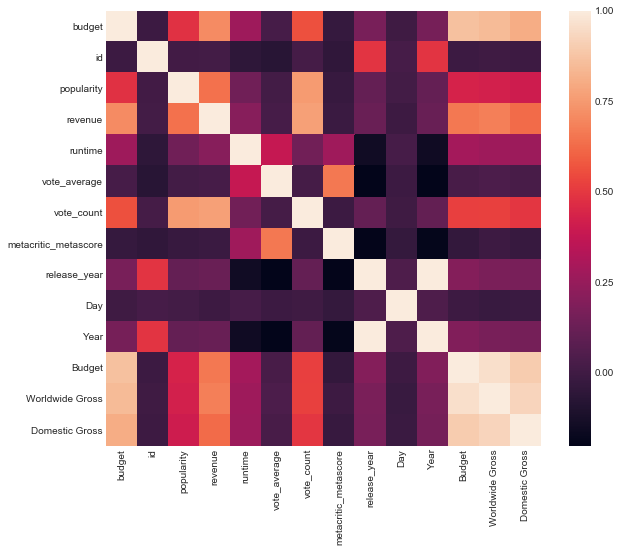

In [192]:
sns.heatmap(critic_revenue.corr(), vmax=1, square=True)

In [193]:
#Defining features and target for this dataset based on co-relation
features = ['Budget']
target = ['Worldwide Gross']

In [194]:
#splitting data set into training and test data set in 0.7/0.3
train, test = train_test_split(critic_revenue,test_size=0.30)
train.head()

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,vote_average,vote_count,metacritic_metascore,release_year,Month,Day,Year,Budget,Worldwide Gross,Domestic Gross
1394,0.354530,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",10025,en,Just My Luck,0.739457,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-05-12,0.048680,...,5.8,0.621229,29.0,2006,May,12,2006,28000000.0,0.375388,0.576897
2186,0.000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name...",19052,en,Light It Up,-0.188328,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-11-04,0.230803,...,6.6,0.043002,43.0,1999,Nov,10,1999,13000000.0,0.089007,0.000291
2759,0.000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",11357,en,Halloween 4: The Return of Michael Myers,0.000000,"[{""name"": ""Dimension Films"", ""id"": 7405}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1988-10-21,0.000000,...,5.9,0.000000,34.0,1988,Oct,1,1988,5000000.0,-0.017606,0.124590
2584,-0.118177,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",398,en,Capote,-0.378816,"[{""name"": ""Sony Pictures Classics"", ""id"": 58},...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2005-09-30,-0.195277,...,6.8,-0.227298,88.0,2005,Sep,30,2005,7000000.0,0.010868,-0.161911
2730,-0.165447,"[{""id"": 27, ""name"": ""Horror""}]",242512,en,Ouija,2.318085,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",2014-10-24,1.710811,...,4.9,3.142238,38.0,2014,Oct,24,2014,5000000.0,-0.013617,0.088707


In [195]:
#Fill the training and test data with require information
X_train = train[features].dropna()
y_train = train[target].dropna()
X_test = test[features].dropna()
y_test = test[target].dropna()

In [196]:
from sklearn import linear_model# compute classification accuracy for the linear regression model
from sklearn import metrics # for the check the error and accuracy of the model
lin = linear_model.LinearRegression()
# train the model on the training set
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [197]:
lin_score_train = lin.score(X_test, y_test)
lin_score_test = lin.score(X_train, y_train)

In [198]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.9082610869579435
Testing score:  0.9227305362307261


In [199]:
yPrediction = lin.predict(X_test)

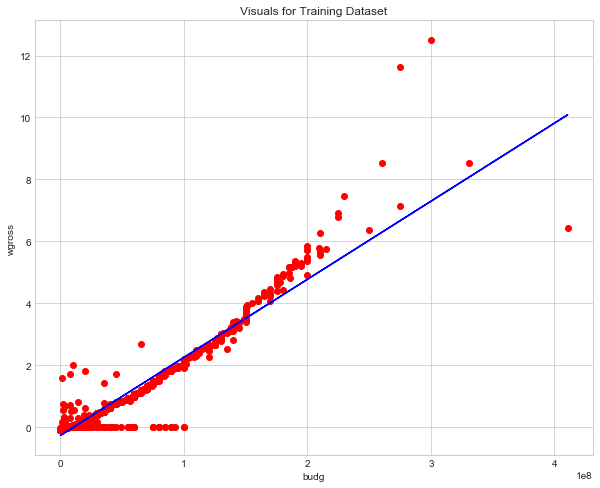

In [200]:
# Visualising the training set results
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

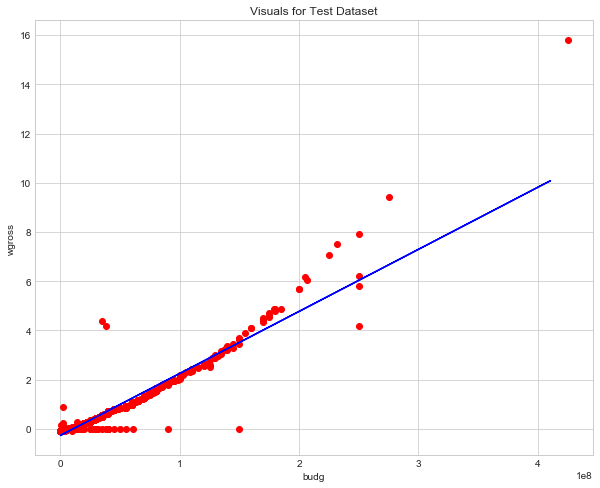

In [201]:
plt.scatter(X_test, y_test , color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Test Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

In [202]:
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [203]:
knn_score_train = knn.score(X_test, y_test)
knn_score_test = knn.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  0.9158032888336229
Testing score:  0.9615581795991047


In [204]:
#another way to work on linear regression

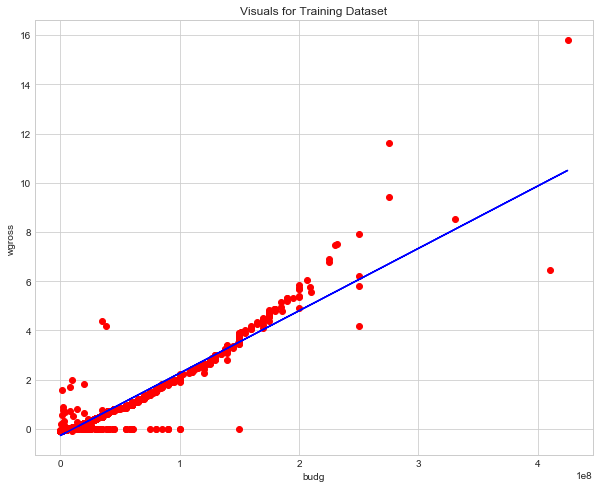

In [205]:
#Splitting the data into Train and Test
from sklearn.cross_validation import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=1/3, random_state=0)


#Fitting simple linear regression to the Training Set
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

#Predicting the prices
pred = regressor.predict(xtest)

#Visualizing the training Test Results 
plt.scatter(xtrain, ytrain, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

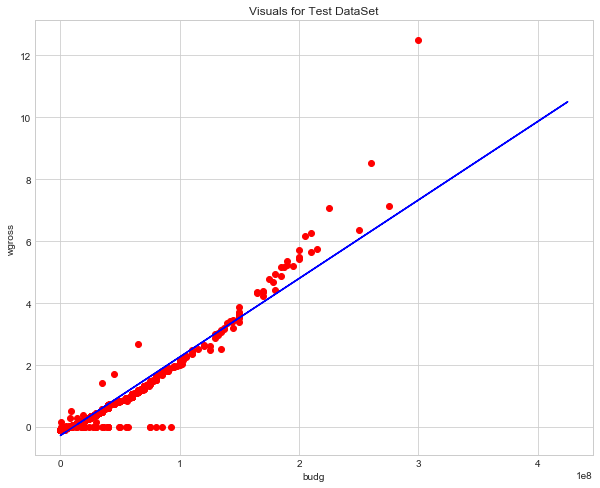

In [206]:
#Visualizing the Test Results 
plt.scatter(xtest, ytest, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title("Visuals for Test DataSet")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()